In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
sys.path.insert(0, '..') #add paernet directory to the list in which packages are searched

In [3]:
import math
import ROOT

Welcome to JupyROOT 6.22/06


In [4]:
ROOT.gStyle.SetOptStat(0)

In [5]:
from funcs import getModulesWithTC, fillTowersIncl

# 1. Filling with cells

# -------------------------------

## 1.1 Silicons

In [6]:
cellsSilic = pd.read_csv('../input/cellPositions/sensorCell_positions.txt' , sep=' ')
cellsSilic.columns= ["layer","waferu","waferv","triggercellu","triggercellv","SC_eta","SC_phi"]

last_CE_E_layer = 28
cellsSilic = cellsSilic[(cellsSilic.layer % 2 == 1) | (cellsSilic.layer > last_CE_E_layer)].reset_index(drop=True)#Only use trigger layers. 
cellsSilic["SC_phi"] = cellsSilic["SC_phi"].replace(0, 1e-5) #Force SCs on border phi=0 to fill positive-phi bins.

In [7]:
etaBinStep = 0.0870
minBinEta = 14
maxBinEta = 36
minEta = minBinEta * etaBinStep
maxEta = maxBinEta * etaBinStep
nBinsEta = maxBinEta - minBinEta

phiBinStep = 2*math.pi/72
minBinPhi = -5
maxBinPhi = 28
minPhi = minBinPhi * phiBinStep
maxPhi = maxBinPhi * phiBinStep
nBinsPhi = maxBinPhi - minBinPhi

In [8]:
modulesWithTC = getModulesWithTC('../input/allocation/allocation_20210421.txt')

In [9]:
EM_cellsOnly = ROOT.TH2D("EM_cellsOnly","",nBinsEta,minEta,maxEta,nBinsPhi,minPhi,maxPhi)
HadSilic_cellsOnly = ROOT.TH2D("HadSilic_cellsOnly","",nBinsEta,minEta,maxEta,nBinsPhi,minPhi,maxPhi)
for l in range(1, 1+int(np.max(cellsSilic['layer'])) ): #layer number
    if (l <= last_CE_E_layer and l%2 == 0): #only using trigger layers 
        continue
    print('layer= ', l)
    for u in range(1+np.max(cellsSilic['waferu'])): #wafer u
        for v in range(1+np.max(cellsSilic['waferv'])): #wafer v
            wafer_data = cellsSilic[(cellsSilic["waferu"]==u) & (cellsSilic["waferv"]==v) & (cellsSilic["layer"]==l)]
            if (len(wafer_data)!=0) and ('l'+str(l)+'-u'+str(u)+'-v'+str(v) in modulesWithTC):
                if(l <= last_CE_E_layer):
                    for index, row in wafer_data.iterrows():
                        EM_cellsOnly.Fill(-1.0*row["SC_eta"], row["SC_phi"], 1./len(wafer_data))
                else:
                    for index, row in wafer_data.iterrows():
                        HadSilic_cellsOnly.Fill(-1.0*row["SC_eta"], row["SC_phi"], 1./len(wafer_data))

layer=  1
layer=  3
layer=  5
layer=  7
layer=  9
layer=  11
layer=  13
layer=  15
layer=  17
layer=  19
layer=  21
layer=  23
layer=  25
layer=  27
layer=  29
layer=  30
layer=  31
layer=  32
layer=  33
layer=  34
layer=  35
layer=  36
layer=  37
layer=  38
layer=  39
layer=  40
layer=  41
layer=  42
layer=  43
layer=  44
layer=  45
layer=  46
layer=  47
layer=  48
layer=  49
layer=  50


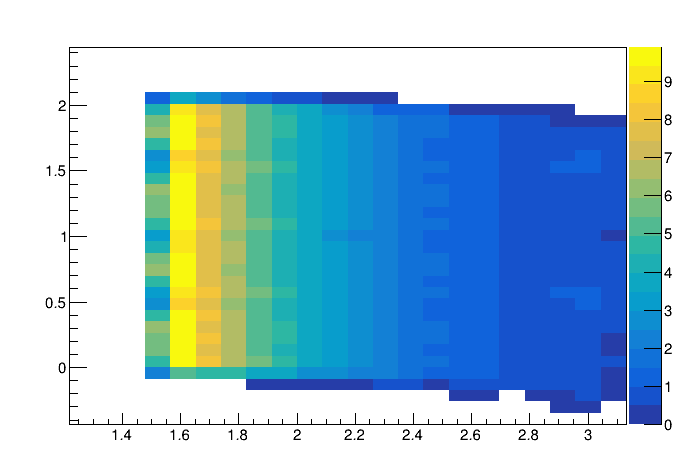

In [10]:
canv_EM_cellsOnly = ROOT.TCanvas()
EM_cellsOnly.Draw("colz")
canv_EM_cellsOnly.Draw()

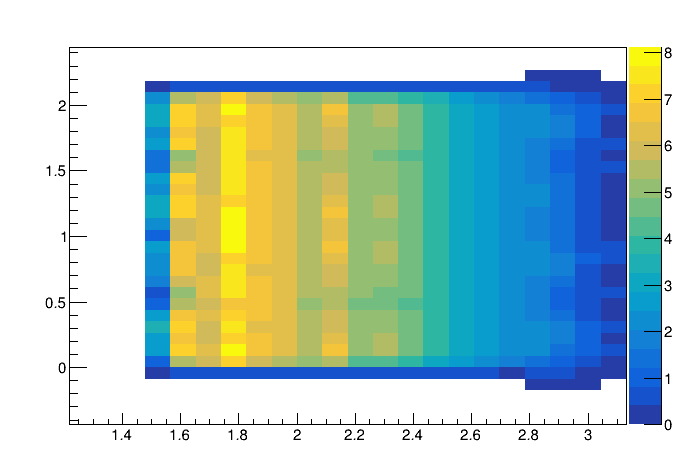

In [11]:
canv_HadSilic_cellsOnly = ROOT.TCanvas()
HadSilic_cellsOnly.Draw("colz")
canv_HadSilic_cellsOnly.Draw()

# -----------------------------

## 1.2 Scintillators

In [12]:
cellsScint = pd.read_csv('../input/cellPositions/TCPositions_sctintillator.csv', sep=' ')
thresh ={
        37 : 1.57,
        38 : 1.58,
        39 : 1.59,
        40 : 1.60,
        41 : 1.79,
        42 :1.81,
        43 :1.83,
        44 : 1.85,
        45 : 1.86,
        46 : 1.88,
        47 : 1.90,
        48 : 1.92,
        49 : 1.93,
        50 :1.95
        }

In [13]:
HadScint_cellsOnly = ROOT.TH2D("HadScint_cellsOnly","",nBinsEta,minEta,maxEta,nBinsPhi,minPhi,maxPhi)

In [14]:
for j in range(37,51):
    m = (cellsScint['triggercelleta']*-1)[(cellsScint['layer']==j) & (cellsScint['triggercelliphi']==1)]
    for eta in m:
        norm = (m>thresh[j]).sum() if eta>thresh[j] else (m<thresh[j]).sum()
        for k in range(24):
            HadScint_cellsOnly.Fill(eta, math.pi/72+k*phiBinStep, 0.5/norm) #0.5 is there because two towers make up an ECON-T   

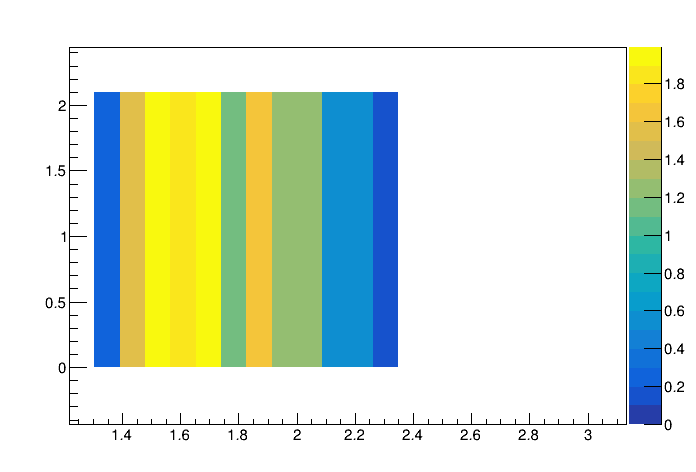

In [15]:
canv_HadScint_cellsOnly = ROOT.TCanvas()
HadScint_cellsOnly.Draw("colz")
canv_HadScint_cellsOnly.Draw()

# 2. Fits

In [16]:
parMtxHadScint = pd.read_pickle('../output/tower_module_mapping_array/param_mtx_had_scint.pkl')
parMtxHadSilic = pd.read_pickle('../output/tower_module_mapping_array/param_mtx_had_silic.pkl')
parMtxEM = pd.read_pickle('../output/tower_module_mapping_array/param_mtx_em.pkl')

In [17]:
HadSilicFit = ROOT.TH2D("HadSilicFit","",nBinsEta,minEta,maxEta,nBinsPhi,minPhi,maxPhi)
HadScintFit = ROOT.TH2D("HadScintFit","",nBinsEta,minEta,maxEta,nBinsPhi,minPhi,maxPhi)
HadFit = ROOT.TH2D("HadFit","",nBinsEta,minEta,maxEta,nBinsPhi,minPhi,maxPhi) #=HadScint+HadSilic
EMFit = ROOT.TH2D("EMFit","",nBinsEta,minEta,maxEta,nBinsPhi,minPhi,maxPhi)
inclusiveFit = ROOT.TH2D("InclusiveFit","",nBinsEta,minEta,maxEta,nBinsPhi,minPhi,maxPhi) #=Had+EM

In [18]:
HadSilicFit = fillTowersIncl(parMtxHadSilic, HadSilicFit, DoNumOfSums=False, N_div=8) #N_div is ignored when DoNumOfSums=True
HadScintFit = fillTowersIncl(parMtxHadScint, HadScintFit, DoNumOfSums=False, N_div=16)

In [19]:
HadFit.Add(HadScintFit)
HadFit.Add(HadSilicFit)

True

In [20]:
EMFit = fillTowersIncl(parMtxEM, EMFit, DoNumOfSums=False, N_div=8)

In [21]:
inclusiveFit.Add(HadFit)
inclusiveFit.Add(EMFit)

True

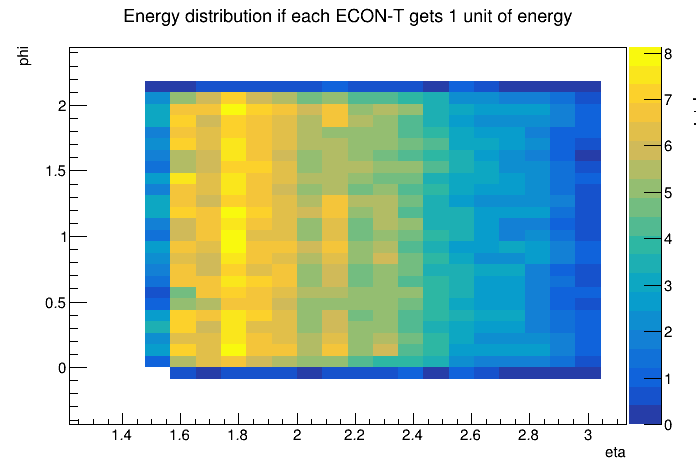

In [22]:
canv_HadSilicFit = ROOT.TCanvas()
HadSilicFit.Draw("colz")
canv_HadSilicFit.Draw()

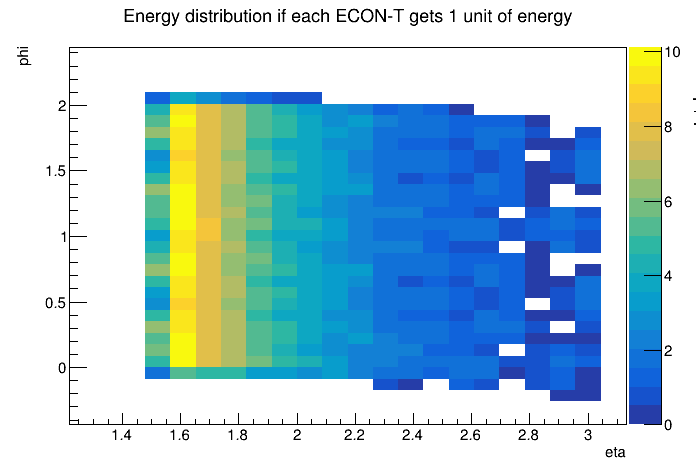

In [23]:
canv_EMFit = ROOT.TCanvas()
EMFit.Draw("colz")
canv_EMFit.Draw()

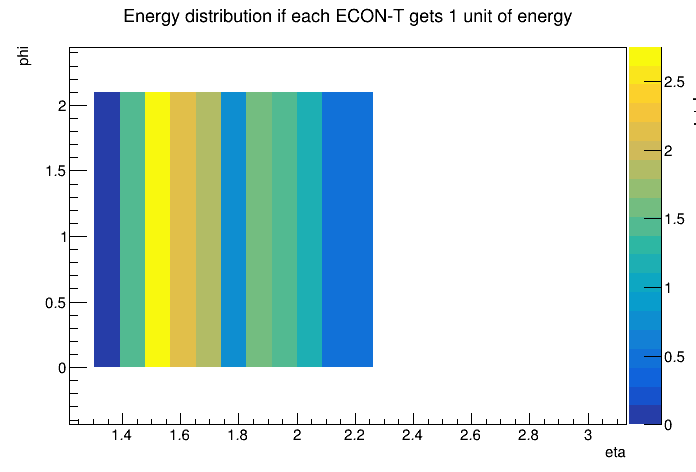

In [24]:
canv_HadScintFit = ROOT.TCanvas()
HadScintFit.Draw("colz")
canv_HadScintFit.Draw()

In [25]:
#-----------------------------------
inclusive_cellsOnly = ROOT.TH2D("Inclusive_cellsOnly","",nBinsEta,minEta,maxEta,nBinsPhi,minPhi,maxPhi)
inclusive_cellsOnly.Add(HadScint_cellsOnly)
inclusive_cellsOnly.Add(HadSilic_cellsOnly)
inclusive_cellsOnly.Add(EM_cellsOnly)
ratio = ROOT.TH2D("ratio","",nBinsEta,minEta,maxEta,nBinsPhi,minPhi,maxPhi)
ratio = inclusiveFit.Clone()
ratio.Divide(inclusive_cellsOnly)


True

In [26]:
inclusive_cellsOnly.Integral()

3618.7506975185474

In [27]:
inclusiveFit.Integral()#should be close to the inclusive_cellsOnly integral

3612.5

In [28]:
ratio.Integral() #should be close to the number of colored bins

520.6498720655102

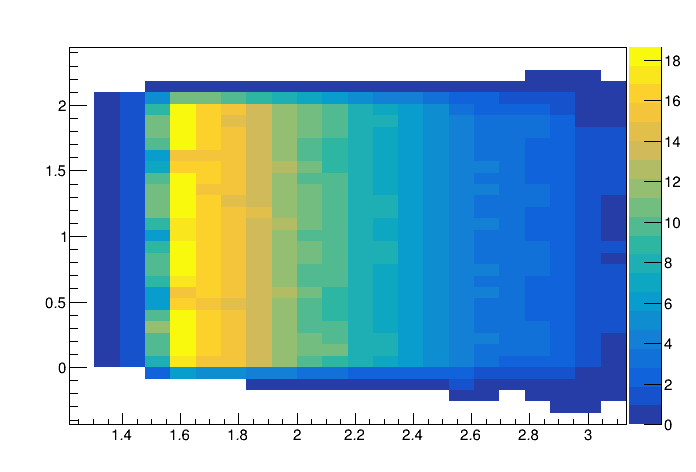

In [29]:
canv_inclusive_cellsOnly = ROOT.TCanvas()
inclusive_cellsOnly.Draw("colz")
canv_inclusive_cellsOnly.Draw()

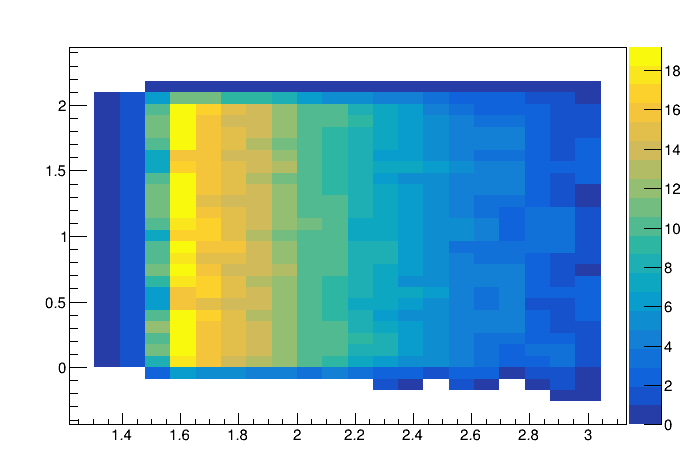

In [30]:
canv_inclusiveFit = ROOT.TCanvas()
inclusiveFit.Draw("colz")
canv_inclusiveFit.Draw()

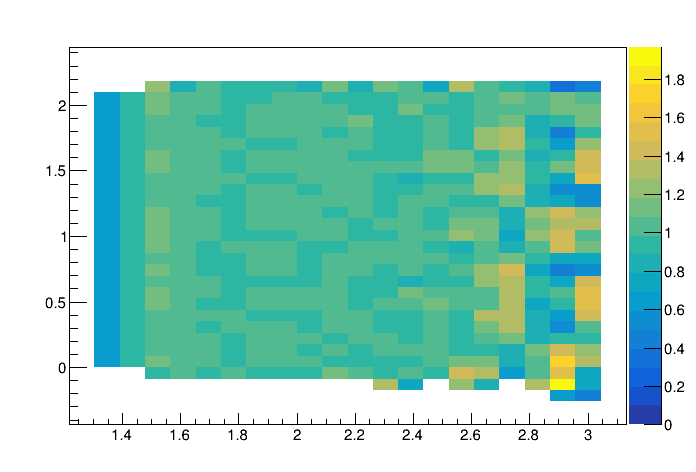

In [31]:
canv_ratio = ROOT.TCanvas()
ratio.Draw("colz")
canv_ratio.Draw()